<a href="https://colab.research.google.com/github/amitadhainje/LearningBERT/blob/master/NLP_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install lime
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [15]:
from google.colab import files
files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [24]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('IMDB Dataset.csv')
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
import nltk
from nltk.corpus import stopwords
import string
import re

oneSetOfStopWords = set(stopwords.words('english')+['``',"''",'...','nbsp','br','/div','div'])

def CleanText(givenText):
    reqText = givenText.lower()
    reqText = re.sub(r"<br />", "", reqText)
    reqText = re.sub(r"=2e", "", reqText)
    reqText = re.sub(r"=2c", "", reqText)
    reqText = re.sub(r"\=", "", reqText)
    reqText = re.sub(r"news.website.http\:\/.*\/.*502503.stm.", "", reqText)
    reqText = re.sub(r"http://www.forcetacticalarmy.com","",reqText)
    reqText = re.sub(r"\'s", " ", reqText)
    reqText = re.sub(r"\'", " ", reqText)
    reqText = re.sub(r":", " ", reqText)
    reqText = re.sub(r"_", " ", reqText)
    reqText = re.sub(r"-", " ", reqText)
    reqText = re.sub(r"\'ve", " have ", reqText)
    reqText = re.sub(r"can't", "can not ", reqText)
    reqText = re.sub(r"n't", " not ", reqText)
    reqText = re.sub(r"i'm", "i am ", reqText)
    reqText = re.sub(r"\'re", " are ", reqText)
    reqText = re.sub(r"\'d", " would ", reqText)
    reqText = re.sub(r"\d", "", reqText)
    reqText = re.sub(r"\b[a-zA-Z]\b","", reqText)
    reqText = re.sub(r"[\,|\.|\&|\;|<|>]","", reqText)
    reqText = re.sub(r"\S*@\S*", " ", reqText)
    reqText = reqText.replace('_','')
    sentenceWords = []
    requiredWords = nltk.word_tokenize(reqText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            sentenceWords.append(word)
    reqText = " ".join(sentenceWords)     
    return reqText

In [26]:
%%time
dataset['TargetVariable'] = np.where(dataset['sentiment'] == 'positive', 1, 0)
newDataset = dataset[dataset['review'].notnull()][:10000]
newDataset['cleaned_text'] = newDataset.review.apply(lambda x: CleanText(x))
finalDf = newDataset[['cleaned_text','TargetVariable']]
finalDf.head()

CPU times: user 12.6 s, sys: 2.74 ms, total: 12.6 s
Wall time: 12.6 s


In [0]:
from sklearn.model_selection import train_test_split
sentences = finalDf['cleaned_text'].values
labels = finalDf['TargetVariable'].values
Xtrain, Xtest, ytrain, ytest = train_test_split(sentences, labels, test_size = 0.25, random_state=0)

In [0]:
vocab_size = 20000
maxlen = 100

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)

In [0]:
class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

batch_size = 64
max_features = vocab_size + 1

def create_model(max_features):
  embedding_dim = 32
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=256))
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dense(24,activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=5, batch_size=batch_size, 
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(Xtrain, ytrain);

Epoch 1/5
118/118 [==============================] - 1s 10ms/step - loss: 0.6735 - accuracy: 0.6521
Epoch 2/5
118/118 [==============================] - 1s 10ms/step - loss: 0.4918 - accuracy: 0.8677
Epoch 3/5
118/118 [==============================] - 1s 10ms/step - loss: 0.2755 - accuracy: 0.9191
Epoch 4/5
118/118 [==============================] - 1s 11ms/step - loss: 0.1725 - accuracy: 0.9517
Epoch 5/5
118/118 [==============================] - 1s 11ms/step - loss: 0.1153 - accuracy: 0.9717


In [46]:
from sklearn import metrics
print('Computing predictions on test set...')
y_preds = pipeline.predict(Xtest)

print('Test accuracy: {:.2f} %'.format(100*metrics.accuracy_score(y_preds, ytest)))

Computing predictions on test set...
40/40 [==============================] - 0s 2ms/step
Test accuracy: 86.80 %


In [47]:
# We choose a sample from test set
idx = 11
text_sample = Xtest[idx]
class_names = ['negative', 'positive']

print('Sample {}: last 80 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-80:]))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[ytest[idx]])

Sample 11: last 80 words (only part used by the model)
--------------------------------------------------
movie starts hilarious second mark continues throughout movie recall scene turn look people laughing perfect actor roll way looks way dressedthe comedic parts great see actors big popular see people like movie currently rated imdb think lets put way seen funny movie since american pie original vacation see want laugh give movie highest thumbs ever given since found imdb great movie site
--------------------------------------------------
Instructions for updating:
Please use `model.predict()` instead.
1/1 [==============================] - 0s 1ms/step
Probability(positive) = 0.9871308
True class: positive


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


79/79 [==============================] - 0s 2ms/step


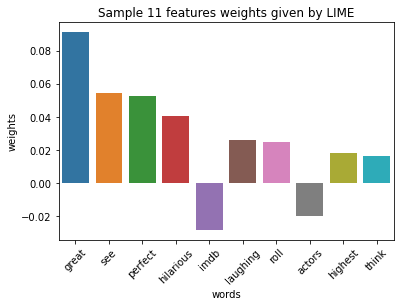

In [49]:
import seaborn as sns
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt


explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));